In [87]:
import copy
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, \
    roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate, GroupKFold

from utils import calculate_balanced_permeability_index_weiss_2024, calculate_cns_mpo_score_wager_2010, get_chembl_drugs_with_descriptors,get_drugbank_small_molecule_drugs


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from xgboost import XGBRegressor

from sklearn.feature_selection import mutual_info_regression

from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
import pprint

## Prepare the datasets 

In [88]:
df_b3db_kc = pd.read_csv("b3db_kc_split_descriptors.tsv", sep="\t")

# https://pubs.acs.org/doi/epdf/10.1021/cn3000907 (picked up by R47) reports sildenafil's logBB as -1.4, citing https://onlinelibrary.wiley.com/doi/10.1111/jnc.13454 as reference. The source measures concentration in cerebro-spinal fluid as a proxy for free (unbound) brain concentration and reports value of ~0.39 unbound (i.e. K(b,uu) vs K(b). Not adjusting for the bound serum concentration does result in -1.4. We disregard these datapoints (and assume it should be permeating).
df_b3db_kc = df_b3db_kc[~df_b3db_kc.names.apply(lambda x: pd.notna(x) and ("Sildenafil" in x or "Tadalafil" in x or "Vardenafil" in x))]
# TODO exclude zolpidem ? 

df_b3db_kc['BBB_numeric'] = df_b3db_kc['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})
df_train_all = df_b3db_kc[df_b3db_kc.split == "training"].copy()
df_test_all = df_b3db_kc[df_b3db_kc.split == "test"].copy()

df_b3db_kc_reg = df_b3db_kc[(pd.notna(df_b3db_kc.logBB)) & (df_b3db_kc.logBB_group != "D")].copy().reset_index(drop=True)
df_train = df_b3db_kc_reg[df_b3db_kc_reg.split=="training"].copy().reset_index(drop=True)

df_train_classification_only = df_b3db_kc[(pd.isna(df_b3db_kc.logBB)) & (df_b3db_kc.split == "training")].copy().reset_index(drop=True) # We use this dataset primarily for studying the quantitative evaluation of the algorithm.

# _mols = set(pd.read_csv("chembl_mol_properties.csv", low_memory=False).standard_inchi)
# df_train = df_train[df_train.inchi.apply(lambda x: x in _mols)].reset_index()

df_test = df_b3db_kc_reg[df_b3db_kc_reg.split=="test"].copy().reset_index(drop=True)

print(f"Read {len(df_b3db_kc_reg)} records, {len(df_train)} in training, and {len(df_test)} in test splits.")

df_train_features = df_train.drop(columns=["inchi", "names", "iupac_name", "smiles", "cid", "record_ids", "logBB", "logBB_group", "BBB+/BBB-",  "BBB+/BBB-_group", "BBB_numeric", "split"])#, "murcko_scaffold_grouped"])
df_train_features_desc2D_chemaxon = df_train_features[[c for c in list(df_train_features) if c.startswith("chemaxon") or c.startswith("desc2D")]]
df_train_features_ecfp_count = df_train_features[[c for c in list(df_train_features) if c.startswith("ecfp")]]
df_train_features_maccs = df_train_features[[c for c in list(df_train_features) if c.startswith("maccs")]]

Read 875 records, 678 in training, and 197 in test splits.


In [122]:
df_drugs = get_chembl_drugs_with_descriptors(descriptors=["desc2D", "ecfp-count", "maccs"])
df_drugs = df_drugs.merge(get_drugbank_small_molecule_drugs(), how="left", on="chembl_id")

/opt/homebrew/lib/python3.11/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
/opt/homebrew/lib/python3.11/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
/opt/homebrew/lib/python3.11/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
/opt/homebrew/lib/python3.11/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
/opt/homebrew/lib/python3.11/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
[10:34:08] Can'

## Remove correlated features
  - Sorts the features by mutual information w-r-t logBB
  - Preserves CNS MPO features 
  - Removes highly correlated features (Pearson correlation above 0.8 with any feature with higher mutual information value w-r-t logBB  

In [123]:
def get_correlated_features(_df, feature, threshold=0.9):
    cor_mtx = _df.corr()
    correlated = []
    for c in list(cor_mtx.columns):
        if c != feature:
            c_a = abs(cor_mtx.loc[feature, c])
            if c_a > threshold:
                correlated.append(c)
    return correlated          

def get_feature_rank_mutual_information_regression(X, y):
    mutual_info_scores = mutual_info_regression(X, y, random_state=42)
    mutual_info_scores_series = pd.Series(mutual_info_scores, index=X.columns)
    return mutual_info_scores_series.sort_values(ascending=False)


In [124]:
CNS_MPO_FEATURES = ["desc2D_TPSA", "desc2D_MolWt", "desc2D_NumHDonors", "chemaxon_logp", "chemaxon_logd", "chemaxon_pka_b"]
CORRELATION_THRESHOLD = 0.8

_selected = CNS_MPO_FEATURES + ["desc2D_NumHAcceptors", "desc2D_HeavyAtomCount"]
_correlated = set()
for _f in _selected + [c for c in get_feature_rank_mutual_information_regression(df_train_features_desc2D_chemaxon, df_train["logBB"]).index if c not in _selected]: 
    if _f not in _correlated:
        if _f not in _selected:
            _selected.append(_f)
        _correlated = _correlated | set(get_correlated_features(df_train_features_desc2D_chemaxon, _f, threshold=CORRELATION_THRESHOLD))
df_train_features_desc2D_chemaxon_filtered = df_train_features_desc2D_chemaxon[_selected]
print(f"Removed {len(list(df_train_features_desc2D_chemaxon)) - len(list(df_train_features_desc2D_chemaxon_filtered))} desc2D+ChemAxon correlated features (threshold: {CORRELATION_THRESHOLD}), {len(list(df_train_features_desc2D_chemaxon_filtered))} remaining")

Removed 56 desc2D+ChemAxon correlated features (threshold: 0.8), 155 remaining


From the remaining set of features, build two sets:
 1) Simple - a shortlisted set of descriptors, selected on subjective perception of interpretability.  
 2) Extended - this set also incorporates remaining non-correlated descriptors. 

In [125]:
SIMPLE_FILTERED_FEATURES = [
    'desc2D_TPSA',
    'desc2D_MolWt',
    'desc2D_NumHDonors',
    'chemaxon_logp',
    'chemaxon_logd',
    'chemaxon_pka_b',
    'desc2D_NumHAcceptors',
    'desc2D_HeavyAtomCount',
    'desc2D_MaxEStateIndex',
    'desc2D_MinEStateIndex',
    'desc2D_MinPartialCharge',
    'desc2D_MaxPartialCharge',
    'desc2D_MaxAbsPartialCharge',
    'desc2D_AvgIpc',
    'desc2D_HallKierAlpha',
    'desc2D_qed',
    'desc2D_MinAbsEStateIndex',
    'desc2D_NumRotatableBonds',
    'desc2D_FractionCSP3',
    'desc2D_BalabanJ',
    'desc2D_NumSaturatedRings',
    'desc2D_NumAliphaticHeterocycles',
    'desc2D_NumSpiroAtoms',
    'desc2D_NumBridgeheadAtoms',
    'desc2D_NumUnspecifiedAtomStereoCenters',
    'desc2D_NumSaturatedCarbocycles',
    'desc2D_NumAtomStereoCenters',
    'desc2D_NumRadicalElectrons',
    'desc2D_NumAmideBonds',
    'desc2D_SPS'
]

DESC_2D_FILTERED_FEATURES = [f for f in SIMPLE_FILTERED_FEATURES if not f.startswith("chemaxon")]

EXTENDED_FILTERED_FEATURES = SIMPLE_FILTERED_FEATURES +[
    'desc2D_EState_VSA8',
    'desc2D_VSA_EState2',
    'desc2D_PEOE_VSA6',
    'desc2D_SlogP_VSA6',
    'desc2D_EState_VSA10',
    'desc2D_SlogP_VSA2',
    'desc2D_PEOE_VSA9',
    'desc2D_VSA_EState1',
    'desc2D_VSA_EState3',
    'desc2D_PEOE_VSA1',
    'desc2D_SMR_VSA1',
    'desc2D_SlogP_VSA3',
    'desc2D_SlogP_VSA1',
    'desc2D_SlogP_VSA5',
    'desc2D_VSA_EState5',
    'desc2D_EState_VSA1',
    'desc2D_EState_VSA2',
    'desc2D_PEOE_VSA10',
    'desc2D_SMR_VSA3',
    'desc2D_FpDensityMorgan3',
    'desc2D_VSA_EState8',
    'desc2D_EState_VSA5',
    'desc2D_EState_VSA6',
    'desc2D_SMR_VSA10',
    'desc2D_fr_Ar_N',
    'desc2D_PEOE_VSA8',
    'desc2D_PEOE_VSA2',
    'desc2D_VSA_EState7',
    'desc2D_PEOE_VSA7',
    'desc2D_PEOE_VSA12',
    'desc2D_EState_VSA4',
    'desc2D_EState_VSA9',
    'desc2D_FpDensityMorgan1',
    'desc2D_EState_VSA3',
    'desc2D_SMR_VSA6',
    'desc2D_fr_bicyclic',
    'desc2D_PEOE_VSA3',
    'desc2D_Alerts',
    'desc2D_Kappa3',
    'desc2D_VSA_EState9',
    'desc2D_VSA_EState10',
    'desc2D_PEOE_VSA14',
    'desc2D_fr_C_O_noCOO',
    'desc2D_VSA_EState4',
    'desc2D_fr_NH1',
    'desc2D_PEOE_VSA11',
    'desc2D_SlogP_VSA8',
    'desc2D_PEOE_VSA4',
    'desc2D_EState_VSA7',
    
    'desc2D_SlogP_VSA10',
    'desc2D_SlogP_VSA4',
    'desc2D_fr_halogen',
    'desc2D_PEOE_VSA13',
    'desc2D_fr_Ar_NH',
    'desc2D_fr_COO',
    'desc2D_SMR_VSA9',
    'desc2D_fr_Al_OH',
    'desc2D_SMR_VSA4',
    'desc2D_fr_pyridine',
    'desc2D_fr_nitro',
    'desc2D_fr_ketone',
    'desc2D_fr_ether',
    'desc2D_fr_aryl_methyl',
    'desc2D_fr_sulfide',
    'desc2D_fr_oxazole',
    'desc2D_fr_piperdine',
    'desc2D_fr_para_hydroxylation',
    'desc2D_fr_ArN',
    'desc2D_fr_furan',
    'desc2D_fr_phenol',
    'desc2D_fr_NH2',
    'desc2D_fr_Ar_COO',
    'desc2D_fr_thiophene',
    'desc2D_fr_Ndealkylation2',
    'desc2D_fr_Imine',
    'desc2D_fr_methoxy',
    'desc2D_fr_amidine',
    'desc2D_PEOE_VSA5',
    'desc2D_fr_guanido',
    'desc2D_fr_unbrch_alkane',
    'desc2D_EState_VSA11',
    'desc2D_fr_oxime',
    'desc2D_fr_imide',
    'desc2D_fr_isothiocyan',
    'desc2D_fr_priamide',
    'desc2D_fr_sulfonamd',
    'desc2D_fr_epoxide',
    'desc2D_fr_C_S',
    'desc2D_fr_azo',
    'desc2D_fr_HOCCN',
    'desc2D_fr_aniline',
    'desc2D_SlogP_VSA11',
    'desc2D_fr_allylic_oxid',
    'desc2D_fr_quatN',
    'desc2D_fr_SH',
    'desc2D_SMR_VSA2',
    'desc2D_SMR_VSA8',
    'desc2D_fr_nitroso',
    'desc2D_SlogP_VSA9', 
    'desc2D_fr_term_acetylene',
    'desc2D_fr_isocyan',
    'desc2D_fr_benzodiazepine',
    'desc2D_fr_thiocyan',
    'desc2D_fr_urea',
    'desc2D_fr_ester',
    'desc2D_fr_thiazole',
    'desc2D_fr_tetrazole',
    'desc2D_fr_sulfone',
    'desc2D_fr_aldehyde',
    'desc2D_fr_N_O',
    'desc2D_fr_Ndealkylation1',
    'desc2D_fr_prisulfonamd',
    'desc2D_fr_piperzine',
    'desc2D_fr_diazo',
    'desc2D_fr_alkyl_carbamate',
    'desc2D_fr_morpholine',
    'desc2D_fr_lactone',
    'desc2D_fr_lactam',
    'desc2D_fr_imidazole',
    'desc2D_fr_hdrzone',
    'desc2D_fr_hdrzine',
    'desc2D_fr_dihydropyridine',
    'desc2D_fr_azide',
    'desc2D_fr_alkyl_halide',
    'desc2D_fr_nitro_arom',
]

Define the evaluation and test criteria up-front.

In addition to the common regression scoring such as (Root) Mean Squared Error and R2, we include a quantitative evaluation. This is used to evaluate how the regression results would translate to classification setting at different logBB thresholds for BBB+/BBB- separation. We use the same thresholds to quantify how many drugs would be classified as BBB-permeable.     

In [126]:
df_test_features = df_test.drop(columns=["inchi", "names", "iupac_name", "smiles", "cid", "record_ids", "logBB", "logBB_group", "BBB+/BBB-",  "BBB+/BBB-_group", "BBB_numeric", "split", "murcko_scaffold_grouped"])
df_test_features_desc2D_chemaxon = df_test_features[[c for c in list(df_test_features) if c.startswith("chemaxon") or c.startswith("desc2D")]]
df_test_features_ecfp_count = df_test_features[[c for c in list(df_test_features) if c.startswith("ecfp")]]
df_test_features_maccs = df_test_features[[c for c in list(df_test_features) if c.startswith("maccs")]]


def evaluate_train(model, X_train, X_groups, y_train):
    return cross_validate(
        model, X_train, y_train,
        groups=X_groups,
        scoring=["r2", "neg_mean_squared_error", "neg_root_mean_squared_error"],
        cv=GroupKFold(5),
        verbose=1,
        return_indices=True,
    )
    

def evaluate_quant(_model, frame_transform):
    _y_class_only_pred = _model.predict(frame_transform(df_train_classification_only))
    _y_class_only_true = df_train_classification_only["BBB+/BBB-"] == "BBB+"
    _y_drugs = _model.predict(frame_transform(df_drugs))
    return {
        "train_classification_roc_auc": roc_auc_score(_y_class_only_true, _y_class_only_pred),
        "train_classification_b_acc_at_-1": balanced_accuracy_score(_y_class_only_true, _y_class_only_pred >= -1),
        "train_classification_b_acc_at_-0.1": balanced_accuracy_score(_y_class_only_true, _y_class_only_pred >= -0.1),
        "train_classification_b_acc_at_0": balanced_accuracy_score(_y_class_only_true, _y_class_only_pred >= 0),
        "train_classification_b_acc_at_0.3": balanced_accuracy_score(_y_class_only_true, _y_class_only_pred >= 0.3),
        
        "fraction_drugs_predicted_BBB+_at_-1": sum(_y_drugs >= -1.0) / len(_y_drugs),
        "fraction_drugs_predicted_BBB+_at_-0.1": sum(_y_drugs >= -0.1) / len(_y_drugs),
        "fraction_drugs_predicted_BBB+_at_0": sum(_y_drugs >= 0.0) / len(_y_drugs),
        "fraction_drugs_predicted_BBB+_at_0.3": sum(_y_drugs >= 0.3) / len(_y_drugs),
    }

# We evaluate balanced accuracy at various logBB threshold as we have only ~21 / 180 compounds in test set below -1 threshold, which otherwise defines BBB+ vs BBB-. 
def evaluate_test(_model, X_test, y_test):
    y_pred = _model.predict(X_test)
    return {
        "r2": r2_score(y_test, y_pred),
        "mean_squared_error": mean_squared_error(y_test, y_pred),
        "root_mean_squared_error": root_mean_squared_error(y_test, y_pred),
        "b_accuracy_at_logbb_-1": balanced_accuracy_score(y_test >= -1.0, y_pred >= -1.0),
        "b_accuracy_at_logbb_-0.1": balanced_accuracy_score(y_test >= -0.1, y_pred >= -0.1),
        "b_accuracy_at_logbb_0": balanced_accuracy_score(y_test >= 0.0, y_pred >= 0.0),
        "b_accuracy_at_logbb_0.3": balanced_accuracy_score(y_test >= 0.3, y_pred >= 0.3),
    }

In [127]:
# We evaluated multiple results obtained using symbolic regression. 
# The results were worse than these from alternative approaches.
# 
# print("""
# Symbolic regression attempts to find an optimal equation to base the regression on. It utilised genetic programming to search the space of possible equations performing mutations and "survival of the fittest" selection at each epoch.
# """)
# import re
# from gplearn.genetic import SymbolicRegressor
# 
# symbolic_regressor = SymbolicRegressor(
#     n_jobs=-1, 
#     verbose=1, 
#     random_state=0,
#     population_size=5000,
#     generations=20,
#     tournament_size=25,
#     function_set=('add', 'sub', 'mul', 'div', "neg", "abs", "sqrt", "inv"),
#     const_range=(-100, 100),
#     parsimony_coefficient=0.01,
#     #stopping_criteria=0.01,
# )
# 
# #X = df_train_features[SIMPLE_FILTERED_FEATURES]
# X = df_train_features[CNS_MPO_FEATURES]
# symbolic_regressor.fit(X, df_train["logBB"])
# 
# # Predict on the test set
# y_pred = symbolic_regressor.predict(df_test[list(X)])
# print("R2 on train set:", r2_score(df_train["logBB"], symbolic_regressor.predict(X)))
# print("R2 on test set:", r2_score(df_test["logBB"], y_pred))
# 
# def _program_to_mapped(program, features):
#     _p = str(program)
#     _pm = ""
#     prev_end = 0
#     for v in re.finditer(r"(X\w*)", _p):
#         _pm += _p[prev_end:v.start()]
#         _pm += features[int(v.groups()[0].lstrip("X"))]
#         prev_end = v.end()
#     _pm += _p[prev_end:]
#     return _pm
#         
# _program_to_mapped(symbolic_regressor._program, list(X))

In [128]:
print("Performance of single-feature linear regression predictor (grouped CV on training dataset)")
_one_feature_regression_results = []
for f in list(df_train_features_desc2D_chemaxon_filtered):
    mod = LinearRegression()
    _r = evaluate_train(mod, X_train=df_train[[f]], X_groups=df_train[["murcko_scaffold_grouped"]], y_train=df_train["logBB"])
    _r_m = {k.replace("test", "train") + "_avg": sum(v) / len(v) for k, v in _r.items() if "test" in k}
    mod.fit(X=df_train[[f]], y=df_train["logBB"])
    
    _r_q = evaluate_quant(mod, lambda x: x[[f]])
    _one_feature_regression_results.append({"feature": f} | _r_m | _r_q)
df_one_feature_regression_results = pd.DataFrame(_one_feature_regression_results).sort_values("train_r2_avg", ascending=False)

df_one_feature_regression_results

Performance of single-feature linear regression predictor (grouped CV on training dataset)


,feature,train_r2_avg,train_neg_mean_squared_error_avg,train_neg_root_mean_squared_error_avg,train_classification_roc_auc,train_classification_b_acc_at_-1,train_classification_b_acc_at_-0.1,train_classification_b_acc_at_0,train_classification_b_acc_at_0.3,fraction_drugs_predicted_BBB+_at_-1,fraction_drugs_predicted_BBB+_at_-0.1,fraction_drugs_predicted_BBB+_at_0,fraction_drugs_predicted_BBB+_at_0.3
0,desc2D_TPSA,0.298183,-0.384080,-0.616454,0.779207,0.621251,0.705603,0.674544,0.555675,0.852919,0.324994,0.256760,0.079100
2,desc2D_NumHDonors,0.133475,-0.472657,-0.684616,0.750415,0.536872,0.705791,0.606483,0.500000,0.947940,0.472833,0.179429,0.000000
6,desc2D_NumHAcceptors,0.130295,-0.474981,-0.685977,0.707389,0.556508,0.669006,0.628363,0.496875,0.950468,0.486732,0.329543,0.008592
11,desc2D_MaxPartialCharge,0.109641,-0.486070,-0.693944,0.679253,0.500000,0.641457,0.597579,0.531045,0.998231,0.360121,0.248168,0.033359
26,desc2D_VSA_EState3,0.102481,-0.488454,-0.696437,0.722786,0.545893,0.663162,0.678320,0.500476,0.950215,0.468031,0.354562,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,desc2D_NumSaturatedRings,-0.034662,-0.563977,-0.747989,0.497989,0.500000,0.487320,0.500000,0.500000,1.000000,0.886783,0.000000,0.000000
36,desc2D_BalabanJ,-0.035066,-0.564304,-0.748143,0.483309,0.500000,0.505573,0.500000,0.500000,1.000000,0.931514,0.000000,0.000000
68,desc2D_fr_bicyclic,-0.035183,-0.564103,-0.748102,0.556257,0.500000,0.500000,0.496648,0.500000,1.000000,1.000000,0.004043,0.000000
42,desc2D_SPS,-0.035698,-0.564522,-0.748350,0.486187,0.500000,0.493344,0.500000,0.500000,1.000000,0.979277,0.000000,0.000000


In [129]:
def get_forward_selected_feature_model_performance(model_creator, X_train, y_train, X_test=None, y_test=None, n_feat=1):
    _res = []
    for n in range(1, n_feat + 1):
        _mod = model_creator()
        sfs = SequentialFeatureSelector(estimator=_mod, n_jobs=-1, n_features_to_select=n)
        sfs.fit(X_train, y_train),
        _z = pd.Series(sfs.get_support(), index=X_train.columns)
        _fs = list(_z[_z==True].index)
        _mod = model_creator()
        _mod.fit(X_train[_fs], y_train)
        _r_q_eval = evaluate_quant(_mod, lambda x: x[_fs])
        y_train_p = _mod.predict(X_train[_fs])
        y_test_p = _mod.predict(X_test[_fs]) if X_test is not None else None
        _res.append({
            "model": _mod.__class__.__name__,
            "n_feat": n,
            "train_r2": r2_score(y_train, y_train_p),
            "train_rmse": root_mean_squared_error(y_train, y_train_p) 
        } | ({
            "test_r2": r2_score(y_test, y_test_p),
            "test_rmse": root_mean_squared_error(y_test, y_test_p) 
        } if y_test_p is not None else {}) | _r_q_eval | {
            "features": _fs,
        })
    return pd.DataFrame(_res)

### CNS MPO feature set 
 - Multi-feature linear regression models. Using forward feature selection, evaluate the impact each feature used in creation of this index on our dataset.

In [130]:
_features = CNS_MPO_FEATURES + ["desc2D_Kappa3"]  # Kappa3 is added as a negative control. 
df_feature_ffs_log_reg_cns_mpo = get_forward_selected_feature_model_performance(
    model_creator=lambda: LinearRegression(), 
    X_train= df_train[_features], 
    y_train=df_train["logBB"],
    X_test= df_test[_features], 
    y_test=df_test["logBB"],
    n_feat=6
)
df_feature_ffs_log_reg_cns_mpo

,model,n_feat,train_r2,train_rmse,test_r2,test_rmse,train_classification_roc_auc,train_classification_b_acc_at_-1,train_classification_b_acc_at_-0.1,train_classification_b_acc_at_0,train_classification_b_acc_at_0.3,fraction_drugs_predicted_BBB+_at_-1,fraction_drugs_predicted_BBB+_at_-0.1,fraction_drugs_predicted_BBB+_at_0,fraction_drugs_predicted_BBB+_at_0.3,features
0,LinearRegression,1,0.311009,0.618261,0.374570,0.603068,0.779207,0.621251,0.705603,0.674544,0.555675,0.852919,0.324994,0.256760,0.079100,[desc2D_TPSA]
1,LinearRegression,2,0.345478,0.602598,0.414410,0.583545,0.781753,0.623032,0.691579,0.699723,0.617376,0.846348,0.322972,0.249684,0.099823,"[desc2D_TPSA, chemaxon_pka_b]"
2,LinearRegression,3,0.377072,0.587874,0.435611,0.572884,0.788179,0.636854,0.694704,0.696349,0.618677,0.826636,0.315390,0.252969,0.118019,"[desc2D_TPSA, chemaxon_logd, chemaxon_pka_b]"
3,LinearRegression,4,0.383814,0.584684,0.429552,0.575951,0.791299,0.648917,0.700291,0.695398,0.612741,0.811473,0.311852,0.253728,0.110690,"[desc2D_TPSA, desc2D_MolWt, chemaxon_logd, che..."
4,LinearRegression,5,0.384629,0.584297,0.429180,0.576138,0.789068,0.647717,0.694953,0.694281,0.618284,0.813242,0.319181,0.258529,0.115744,"[desc2D_TPSA, desc2D_MolWt, chemaxon_logp, che..."
5,LinearRegression,6,0.387145,0.583102,0.427048,0.577213,0.783241,0.645007,0.685560,0.683295,0.615740,0.814253,0.322972,0.264594,0.116250,"[desc2D_TPSA, desc2D_MolWt, desc2D_NumHDonors,..."


### Simple feature set
 Evaluate linear regression models built using forward feature selection. 

In [131]:
_features = SIMPLE_FILTERED_FEATURES
df_feature_ffs_log_reg_simple = get_forward_selected_feature_model_performance(
    model_creator=lambda: LinearRegression(), 
    X_train= df_train[_features], 
    y_train=df_train["logBB"],  
    # X_test= df_test[_features], 
    # y_test=df_test["logBB"],
    n_feat=12
)
df_feature_ffs_log_reg_simple

,model,n_feat,train_r2,train_rmse,train_classification_roc_auc,train_classification_b_acc_at_-1,train_classification_b_acc_at_-0.1,train_classification_b_acc_at_0,train_classification_b_acc_at_0.3,fraction_drugs_predicted_BBB+_at_-1,fraction_drugs_predicted_BBB+_at_-0.1,fraction_drugs_predicted_BBB+_at_0,fraction_drugs_predicted_BBB+_at_0.3,features
0,LinearRegression,1,0.311009,0.618261,0.779207,0.621251,0.705603,0.674544,0.555675,0.852919,0.324994,0.256760,0.079100,[desc2D_TPSA]
1,LinearRegression,2,0.347020,0.601887,0.786610,0.625991,0.703246,0.685922,0.591996,0.832954,0.323730,0.252464,0.089967,"[desc2D_TPSA, desc2D_NumHAcceptors]"
2,LinearRegression,3,0.361873,0.595002,0.788474,0.621604,0.703106,0.677259,0.583101,0.835734,0.292899,0.236543,0.089714,"[desc2D_TPSA, desc2D_NumHAcceptors, desc2D_Max..."
3,LinearRegression,4,0.369455,0.591457,0.796660,0.620487,0.714977,0.682841,0.595593,0.835734,0.308314,0.252464,0.107405,"[desc2D_TPSA, desc2D_NumHAcceptors, desc2D_Max..."
4,LinearRegression,5,0.381148,0.585947,0.795129,0.629674,0.698471,0.691985,0.618926,0.831691,0.302502,0.249684,0.115492,"[desc2D_TPSA, chemaxon_pka_b, desc2D_NumHAccep..."
5,LinearRegression,6,0.388647,0.582387,0.800635,0.628474,0.699505,0.699308,0.627428,0.824867,0.299975,0.242608,0.114986,"[desc2D_TPSA, chemaxon_pka_b, desc2D_NumHAccep..."
6,LinearRegression,7,0.392891,0.580362,0.800101,0.620487,0.697314,0.700613,0.626642,0.829416,0.295931,0.239323,0.111195,"[desc2D_TPSA, chemaxon_pka_b, desc2D_NumHAccep..."
7,LinearRegression,8,0.431619,0.561546,0.801979,0.631040,0.704057,0.696000,0.616194,0.819055,0.304018,0.250442,0.121557,"[desc2D_TPSA, chemaxon_logd, chemaxon_pka_b, d..."
8,LinearRegression,9,0.445768,0.554512,0.818903,0.642379,0.731384,0.706671,0.622400,0.799343,0.298206,0.250190,0.121051,"[desc2D_TPSA, chemaxon_logd, chemaxon_pka_b, d..."
9,LinearRegression,10,0.447790,0.553500,0.818075,0.646207,0.731445,0.708326,0.623744,0.792014,0.300986,0.252211,0.126106,"[desc2D_TPSA, chemaxon_logd, chemaxon_pka_b, d..."


In [132]:
_features = EXTENDED_FILTERED_FEATURES
df_feature_ffs_log_reg_simple = get_forward_selected_feature_model_performance(
    model_creator=lambda: LinearRegression(), 
    X_train= df_train[_features], 
    y_train=df_train["logBB"],
    # X_test= df_test[_features],
    # y_test=df_test["logBB"],
    n_feat=12
)
df_feature_ffs_log_reg_simple

,model,n_feat,train_r2,train_rmse,train_classification_roc_auc,train_classification_b_acc_at_-1,train_classification_b_acc_at_-0.1,train_classification_b_acc_at_0,train_classification_b_acc_at_0.3,fraction_drugs_predicted_BBB+_at_-1,fraction_drugs_predicted_BBB+_at_-0.1,fraction_drugs_predicted_BBB+_at_0,fraction_drugs_predicted_BBB+_at_0.3,features
0,LinearRegression,1,0.311009,0.618261,0.779207,0.621251,0.705603,0.674544,0.555675,0.852919,0.324994,0.256760,0.079100,[desc2D_TPSA]
1,LinearRegression,2,0.347440,0.601694,0.764189,0.629653,0.675212,0.667508,0.594375,0.834723,0.348244,0.283043,0.095274,"[desc2D_TPSA, desc2D_PEOE_VSA1]"
2,LinearRegression,3,0.384887,0.584175,0.785339,0.647695,0.679760,0.684696,0.592180,0.810210,0.357341,0.290371,0.107910,"[desc2D_TPSA, desc2D_PEOE_VSA1, desc2D_fr_COO]"
3,LinearRegression,4,0.407813,0.573185,0.795569,0.620880,0.709382,0.692784,0.595178,0.834218,0.354309,0.293404,0.111448,"[desc2D_TPSA, desc2D_PEOE_VSA1, desc2D_EState_..."
4,LinearRegression,5,0.432104,0.561306,0.804515,0.613617,0.700841,0.697214,0.631998,0.828911,0.345969,0.280516,0.128633,"[desc2D_TPSA, chemaxon_pka_b, desc2D_PEOE_VSA1..."
5,LinearRegression,6,0.442796,0.555997,0.801815,0.612107,0.696001,0.693386,0.631998,0.829922,0.350265,0.285064,0.128886,"[desc2D_TPSA, chemaxon_pka_b, desc2D_PEOE_VSA1..."
6,LinearRegression,7,0.451806,0.551483,0.800370,0.605652,0.696913,0.696926,0.631295,0.838767,0.332575,0.273439,0.127117,"[desc2D_TPSA, chemaxon_pka_b, desc2D_MaxPartia..."
7,LinearRegression,8,0.470080,0.542214,0.802086,0.602300,0.697925,0.699924,0.637231,0.839019,0.339146,0.278494,0.132424,"[desc2D_TPSA, chemaxon_pka_b, desc2D_MaxPartia..."
8,LinearRegression,9,0.481558,0.536309,0.788592,0.601658,0.677342,0.681183,0.630073,0.841041,0.343695,0.281526,0.138236,"[desc2D_TPSA, chemaxon_pka_b, desc2D_MaxPartia..."
9,LinearRegression,10,0.491308,0.531242,0.777529,0.607245,0.673763,0.668687,0.625460,0.832702,0.340662,0.280516,0.137731,"[desc2D_TPSA, chemaxon_pka_b, desc2D_MaxPartia..."


In [133]:
_features = EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs)
df_feature_ffs_log_reg_simple = get_forward_selected_feature_model_performance(
    model_creator=lambda: LinearRegression(), 
    X_train= df_train[_features], 
    y_train=df_train["logBB"],
    # X_test= df_test[_features],
    # y_test=df_test["logBB"],
    n_feat=8
)
df_feature_ffs_log_reg_simple

,model,n_feat,train_r2,train_rmse,train_classification_roc_auc,train_classification_b_acc_at_-1,train_classification_b_acc_at_-0.1,train_classification_b_acc_at_0,train_classification_b_acc_at_0.3,fraction_drugs_predicted_BBB+_at_-1,fraction_drugs_predicted_BBB+_at_-0.1,fraction_drugs_predicted_BBB+_at_0,fraction_drugs_predicted_BBB+_at_0.3,features
0,LinearRegression,1,0.311009,0.618261,0.779207,0.621251,0.705603,0.674544,0.555675,0.852919,0.324994,0.256760,0.079100,[desc2D_TPSA]
1,LinearRegression,2,0.347440,0.601694,0.764189,0.629653,0.675212,0.667508,0.594375,0.834723,0.348244,0.283043,0.095274,"[desc2D_TPSA, desc2D_PEOE_VSA1]"
2,LinearRegression,3,0.384887,0.584175,0.785339,0.647695,0.679760,0.684696,0.592180,0.810210,0.357341,0.290371,0.107910,"[desc2D_TPSA, desc2D_PEOE_VSA1, desc2D_fr_COO]"
3,LinearRegression,4,0.407813,0.573185,0.795569,0.620880,0.709382,0.692784,0.595178,0.834218,0.354309,0.293404,0.111448,"[desc2D_TPSA, desc2D_PEOE_VSA1, desc2D_EState_..."
4,LinearRegression,5,0.432104,0.561306,0.804515,0.613617,0.700841,0.697214,0.631998,0.828911,0.345969,0.280516,0.128633,"[desc2D_TPSA, chemaxon_pka_b, desc2D_PEOE_VSA1..."
5,LinearRegression,6,0.450327,0.552227,0.789706,0.625825,0.691531,0.669865,0.630199,0.820824,0.350013,0.285823,0.133687,"[desc2D_TPSA, chemaxon_pka_b, desc2D_PEOE_VSA1..."
6,LinearRegression,7,0.461444,0.546614,0.792381,0.623114,0.699680,0.677185,0.630571,0.815264,0.353551,0.289108,0.135709,"[desc2D_TPSA, chemaxon_pka_b, desc2D_PEOE_VSA1..."
7,LinearRegression,8,0.469000,0.542766,0.796084,0.619204,0.702783,0.688005,0.634088,0.817539,0.353298,0.284054,0.132676,"[desc2D_TPSA, chemaxon_pka_b, desc2D_PEOE_VSA1..."


## Deriving a simplistic permeability index
 We attempt building a simplistic, easily implementable permeability index based on a minimal set of features, which could be used as a heuristic in molecule assessment.
 
We report R2 and MSE over the entirety of the dataset as well as R2 and MSE on the test set 

In [135]:
from itertools import combinations

rv = []
for _features in [list(c) for n in range(2) for c in combinations(SIMPLE_FILTERED_FEATURES, n + 1)]:
    mod = LinearRegression().fit(df_b3db_kc_reg[_features], df_b3db_kc_reg["logBB"])
    pred = mod.predict(df_b3db_kc_reg[_features])
    #mod_tt = LinearRegression().fit(df_train[_features], df_train["logBB"])
    #pred_tt = mod_tt.predict(df_test[_features])
    rv.append({
        "r2": r2_score(df_b3db_kc_reg["logBB"], pred),
        "mse": mean_squared_error(df_b3db_kc_reg["logBB"], pred),
        #"r2_test": r2_score(df_test["logBB"], pred_tt),
        #"mse_test": mean_squared_error(df_test["logBB"], pred_tt),
        "features": _features,
    })
df = pd.DataFrame(rv).sort_values("mse", ascending=True).head(500)
df.head(50)

,r2,mse,features
34,0.362160,0.357733,"[desc2D_TPSA, chemaxon_pka_b]"
32,0.356968,0.360646,"[desc2D_TPSA, chemaxon_logp]"
36,0.355879,0.361256,"[desc2D_TPSA, desc2D_HeavyAtomCount]"
35,0.354768,0.361879,"[desc2D_TPSA, desc2D_NumHAcceptors]"
33,0.352979,0.362883,"[desc2D_TPSA, chemaxon_logd]"
30,0.351262,0.363846,"[desc2D_TPSA, desc2D_MolWt]"
50,0.340706,0.369766,"[desc2D_TPSA, desc2D_NumAliphaticHeterocycles]"
49,0.339403,0.370497,"[desc2D_TPSA, desc2D_NumSaturatedRings]"
58,0.338310,0.371110,"[desc2D_TPSA, desc2D_SPS]"
42,0.336891,0.371906,"[desc2D_TPSA, desc2D_AvgIpc]"


Balancing the simplicity and goodness of fit we limit the index to TPSA and logP, with an addition of SPS being considered initially but excluded.
We create a two-parameter index by approximating the coefficients of the linear regression model.

Best index-like set of features based on CNS MPO components
Coefficient + intercept: [-0.01002808  0.07352107] 0.30949963917829076
Train R2: 0.3433342789783014
Train MSE: 0.36431329706965443
Test R2: 0.3994109811248412
Test MSE: 0.3492462672867755
Test b.acc classification at logBB=-1: 0.6165254237288136
Fraction drugs predicted BBB+ at -1 0.8486226939600707
Test b.acc classification at logBB=0: 0.7556701030927835
Fraction drugs predicted BBB+ at 0 0.27394490775840286


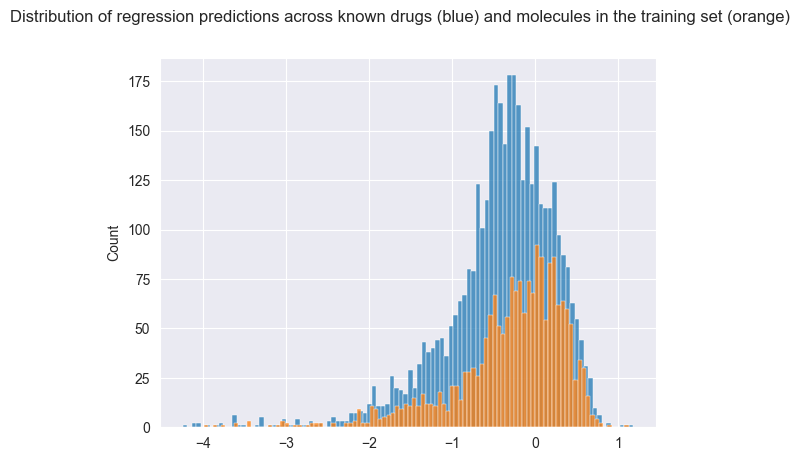

In [147]:
_mod = LinearRegression()
_feats = ["desc2D_TPSA", "chemaxon_logp"]#, "desc2D_SPS"] 
_mod.fit(X=df_train[_feats], y=df_train["logBB"])
_r_q_eval = evaluate_quant(_mod, lambda x: x[_feats])
print("Best index-like set of features based on CNS MPO components")
print("Coefficient + intercept:", _mod.coef_, _mod.intercept_)
print("Train R2:", r2_score( df_train["logBB"], _mod.predict(df_train[_feats])))
print("Train MSE:", mean_squared_error( df_train["logBB"], _mod.predict(df_train[_feats])))
#print("Train classification b.acc at -1:", _r_q_eval["train_classification_b_acc_at_-1"])
#print("Train classification b.acc at 0:", _r_q_eval["train_classification_b_acc_at_0"])
print("Test R2:", r2_score( df_test["logBB"], _mod.predict(df_test[_feats])))
print("Test MSE:", mean_squared_error( df_test["logBB"], _mod.predict(df_test[_feats])))
print("Test b.acc classification at logBB=-1:", balanced_accuracy_score(df_test["logBB"] >= -1, _mod.predict(df_test[_feats]) >= -1))
print("Fraction drugs predicted BBB+ at -1", _r_q_eval["fraction_drugs_predicted_BBB+_at_-1"])
print("Test b.acc classification at logBB=0:", balanced_accuracy_score(df_test["logBB"] >= 0, _mod.predict(df_test[_feats]) >= 0))
print("Fraction drugs predicted BBB+ at 0", _r_q_eval["fraction_drugs_predicted_BBB+_at_0"])
ax = sns.histplot(_mod.predict(df_drugs[_feats]), bins=100)
sns.histplot(_mod.predict(df_train_classification_only[_feats]), bins=100, ax = ax)
_ = plt.suptitle("Distribution of regression predictions across known drugs (blue) and molecules in the training set (orange)")

In [148]:
ind = lambda x: (35 - (x.desc2D_TPSA - 7 * x.chemaxon_logp)) / 100
ind_res_train = pd.DataFrame(df_train.apply(axis=1, func=ind))
ind_res_test = pd.DataFrame(df_test.apply(axis=1, func=ind))
print("Derived, simplified index with pinned regression results.")
print("Train R2:", r2_score(df_train["logBB"], ind_res_train))
print("Test  R2:", r2_score(df_test["logBB"], ind_res_test))
print("Replacing with ")

Derived, simplified index with pinned regression results.
Train R2: 0.34118251427562685
Test  R2: 0.40294911582964965


In [156]:
ind = lambda x: (35 - (x.desc2D_TPSA - 7 * x.desc2D_MolLogP)) / 100
ind_res_train = pd.DataFrame(df_train.apply(axis=1, func=ind))
ind_res_test = pd.DataFrame(df_test.apply(axis=1, func=ind))
print("Derived, simplified index with pinned regression results using MolLogP:.")
print("Train R2:", r2_score(df_train["logBB"], ind_res_train))
print("Test  R2:", r2_score(df_test["logBB"], ind_res_test))
print("ChemAxon logP vs MolLogP")
sns.scatterplot(df_b3db_kc_reg, x="chemaxon_logp", y="desc2D_MolLogP")

Derived, simplified index with pinned regression results.
Train R2: 0.313941675441472
Test  R2: 0.40450165995820775


In [220]:


# An alternative to logP calculation from https://jpharmsci.org/article/S0022-3549(16)32908-2 
#We proposed a simple equation based on the number of carbon atoms, NC, and the number of hetero atoms, NHET: logP=1.46(±0.02)+0.11(±0.001) NC−0.11(±0.001) NHET
#lambda x: logP=1.46+0.11 NC−0.11(±0.001) NHET
from rdkit import Chem
pat = Chem.MolFromSmarts("[#6]")
alt_logP = df_b3db_kc_reg.apply(axis=1, func=lambda x: 1.46 + 0.11*len(Chem.MolFromSmiles(x.smiles).GetSubstructMatches(pat)) - 0.11*x.desc2D_NumHeteroatoms)
#sns.scatterplot(x=alt_logP, y=df_b3db_kc_reg.desc2D_MolLogP)

print("Corr AltLogP - desc2D_MolLogP", df_b3db_kc_reg.desc2D_MolLogP.corr(alt_logP))
print("Corr AltLogP - chemaxon_logp", df_b3db_kc_reg.chemaxon_logp.corr(alt_logP))

ind = lambda x: (35 - (x.desc2D_TPSA - 7 * (1.46 + 0.11*len(Chem.MolFromSmiles(x.smiles).GetSubstructMatches(pat)) - 0.11*x.desc2D_NumHeteroatoms))) / 100
ind_res_train = pd.DataFrame(df_train.apply(axis=1, func=ind))
ind_res_test = pd.DataFrame(df_test.apply(axis=1, func=ind))
print("Derived, simplified index with pinned regression results using alternative logP calculation.")
print("Train R2:", r2_score(df_train["logBB"], ind_res_train))
print("Test  R2:", r2_score(df_test["logBB"], ind_res_test))
print("ChemAxon logP vs MolLogP")
#sns.scatterplot(df_b3db_kc_reg, x="chemaxon_logp", y="desc2D_MolLogP")
_feats = ["desc2D_TPSA", "chemaxon_logp"]#, "desc2D_SPS"]
_df = df_train.copy()
_df["alt_logp"] = _df.apply(axis=1, func=lambda x: 1.46 + 0.11*len(Chem.MolFromSmiles(x.smiles).GetSubstructMatches(pat)) - 0.11*x.desc2D_NumHeteroatoms)
_mod.fit(X=_df[["desc2D_TPSA", "alt_logp"]], y=_df["logBB"])
print("Best index-like set of features based on CNS MPO components")
print("Coefficient + intercept:", _mod.coef_, _mod.intercept_)

Corr AltLogP - desc2D_MolLogP 0.7466373187381954
Corr AltLogP - chemaxon_logp 0.6111811032767115
Derived, simplified index with pinned regression results using alternative logP calculation.
Train R2: 0.3201267115023425
Test  R2: 0.3779125671619886
ChemAxon logP vs MolLogP
Best index-like set of features based on CNS MPO components
Coefficient + intercept: [-0.01125746  0.16807011] 0.09444943551702094


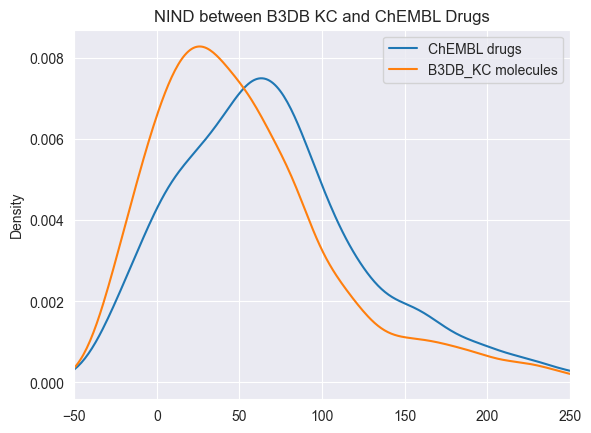

In [221]:
def _calculate_nind(row):
    return row.desc2D_TPSA - 7*row.chemaxon_logp

_drugs_nind = df_drugs.apply(_calculate_nind, axis=1) 
ax = _drugs_nind.plot(kind="kde")
ax = df_b3db_kc.apply(func=_calculate_nind, axis=1).plot(kind="kde")
#_ = ax.vlines(x=35.0, ymin=0, ymax=0.01, colors='green')
ax.set_xlim([-50, 250])
ax.set_title("NIND between B3DB KC and ChEMBL Drugs")
_ = ax.legend(labels=["ChEMBL drugs", "B3DB_KC molecules"])
print("")
#print(f"{sum(_drugs_nind < 70)} / {}")
#print(f"{sum() / len(df_drugs):.2f} ({}/{len(df_drugs)})")

In [169]:
# Follow - up analysis of TPSA vs NIND. NIND (via negative logP) handles the cases where TPSA is 0.
# sns.scatterplot(df_b3db_kc_reg,x="desc2D_TPSA", y="chemaxon_logp")
# df_b3db_kc_reg[df_b3db_kc_reg.desc2D_TPSA == 0][["names", "smiles", "logBB", "desc2D_TPSA", "chemaxon_logp"]]

Best fit logistic regression based on CNS_MPO score, R2: -0.02469, neg MSE: -0.5598
Best fit logistic regression based on BPI score, R2: 0.2358, neg MSE: -0.4231
Best fit logistic regression based on NIND, R2: 0.3325, neg MSE: -0.3662


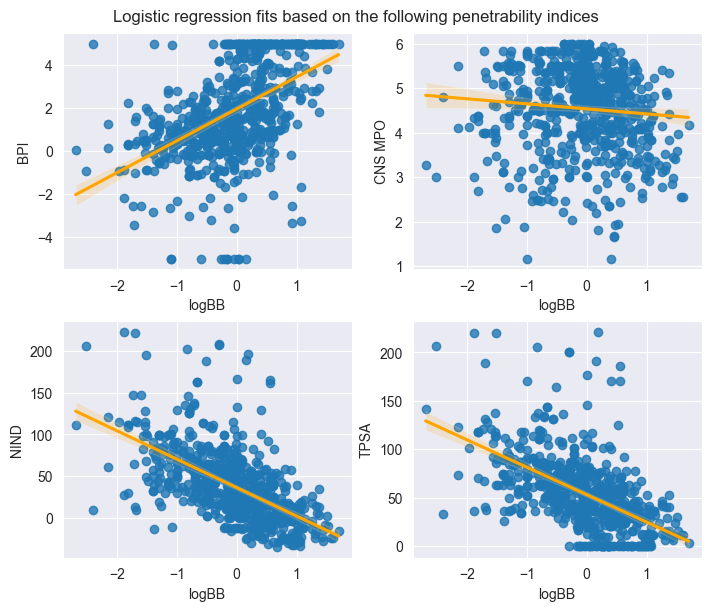

In [224]:
y_train_cns_mpo = df_train.apply(axis=1, func=lambda x: calculate_cns_mpo_score_wager_2010(
    c_log_p=x.chemaxon_logp, 
    c_log_d=x.chemaxon_logd, 
    mw=x.desc2D_MolWt, 
    tpsa=x.desc2D_TPSA, 
    hbd=x.desc2D_NumHDonors, 
    pka=x.chemaxon_pka_b))

y_train_bpi = df_train.apply(axis=1, func=lambda x: calculate_balanced_permeability_index_weiss_2024(
    c_log_d=x["chemaxon_logd"], 
    psa=x["desc2D_TPSA"] if x["desc2D_TPSA"] >= 3.24  else 3.24,  # 3.24 is the lowest value above 0. 
    hac=x["desc2D_HeavyAtomCount"]) 
).apply(lambda x: -5 if x < -5 else 5 if x > 5 else x)

_regression_res_cns_mpo = evaluate_train(
    LinearRegression(), pd.DataFrame([y_train_cns_mpo]).T, df_train.murcko_scaffold_grouped, df_train["logBB"]
)
_r_cns_mpo = {k.replace("test", "train"): sum(v)/len(v) for k, v in _regression_res_cns_mpo.items() if "test" in k}
print(f"Best fit logistic regression based on CNS_MPO score, R2: {_r_cns_mpo['train_r2']:0.4}, neg MSE: {_r_cns_mpo['train_neg_mean_squared_error']:0.4}")

_regression_res_bpi = evaluate_train(
    LinearRegression(), pd.DataFrame([y_train_bpi]).T, df_train.murcko_scaffold_grouped, df_train["logBB"]
)
_r_bpi = {k.replace("test", "train"): sum(v)/len(v) for k, v in _regression_res_bpi.items() if "test" in k}
print(f"Best fit logistic regression based on BPI score, R2: {_r_bpi['train_r2']:0.4}, neg MSE: {_r_bpi['train_neg_mean_squared_error']:0.4}")

y_train_nind = df_train.apply(axis=1, func=_calculate_nind)

_regression_res_nind = evaluate_train(LinearRegression(), pd.DataFrame([y_train_nind]).T, df_train.murcko_scaffold_grouped, df_train["logBB"])
_r_nind =  {k.replace("test", "train"): sum(v)/len(v) for k, v in _regression_res_nind.items() if "test" in k}
print(f"Best fit logistic regression based on NIND, R2: {_r_nind['train_r2']:0.4}, neg MSE: {_r_nind['train_neg_mean_squared_error']:0.4}")

_nr = 2
_nc = 2
fig, axs = plt.subplots(_nr, _nc, figsize=(7, 6), constrained_layout=True)
fig.suptitle("Logistic regression fits based on the following penetrability indices")
for i, (_name, _vals) in enumerate([
    ("BPI", y_train_bpi),
    ("NIND", y_train_nind),
    ("CNS MPO", y_train_cns_mpo),
    ("TPSA", df_train["desc2D_TPSA"]),
]):
    ax = axs[i % _nc, i // _nr] 
    sns.regplot(x=df_train.logBB, y=_vals, line_kws={"color": "orange"}, ax=ax)
    _ = ax.set_ylabel(_name)

In [171]:
### A screen of models and feature sets
#In order to establish the direction of single optimised model building we  

In [225]:
from sklearn.ensemble import ExtraTreesRegressor

_results = []
for m in [
    LinearRegression(),
    XGBRegressor(random_state=42),
    RandomForestRegressor(random_state=42), 
    ExtraTreesRegressor(random_state=42),
]:
    for _fsn, _feats in [
        ("CNS MPO", CNS_MPO_FEATURES),
        ("2D Simple", SIMPLE_FILTERED_FEATURES),
        ("2D Desc-only", DESC_2D_FILTERED_FEATURES),
        ("2D Extended", EXTENDED_FILTERED_FEATURES),
        ("MACCS", list(df_train_features_maccs)),
        ("ECFP-count", list(df_train_features_ecfp_count)),
        ("2D Simple + MACCS", SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Desc-only + MACCS", DESC_2D_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS + ECFP-count", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs) + list(df_train_features_ecfp_count)),
    ]:
        _r_tr = evaluate_train(copy.deepcopy(m), df_train[_feats], df_train.murcko_scaffold_grouped, df_train["logBB"])
        _r_te = evaluate_test(copy.deepcopy(m).fit(df_train[_feats], df_train["logBB"]), X_test=df_test[_feats], y_test=df_test["logBB"])
        _r_q_eval = evaluate_quant(copy.deepcopy(m).fit(df_train[_feats], df_train["logBB"]), lambda x: x[_feats])
        
        _results.append({
            "model": m.__class__.__name__,
            "feature_set": _fsn,
            "train_r2": sum(_r_tr["test_r2"]) / len(_r_tr["test_r2"]),
            "train_nMSE": sum(_r_tr["test_neg_mean_squared_error"]) / len(_r_tr["test_neg_mean_squared_error"]),
        } | {"test_" + k: v for k, v in _r_te.items()} | _r_q_eval)
df_algo_results = pd.DataFrame(_results)
df_algo_results

,model,feature_set,train_r2,train_nMSE,test_r2,test_mean_squared_error,test_root_mean_squared_error,test_b_accuracy_at_logbb_-1,test_b_accuracy_at_logbb_-0.1,test_b_accuracy_at_logbb_0,test_b_accuracy_at_logbb_0.3,train_classification_roc_auc,train_classification_b_acc_at_-1,train_classification_b_acc_at_-0.1,train_classification_b_acc_at_0,train_classification_b_acc_at_0.3,fraction_drugs_predicted_BBB+_at_-1,fraction_drugs_predicted_BBB+_at_-0.1,fraction_drugs_predicted_BBB+_at_0,fraction_drugs_predicted_BBB+_at_0.3
0,LinearRegression,CNS MPO,3.731713e-01,-3.446447e-01,4.270477e-01,3.331753e-01,5.772134e-01,0.610876,0.761559,0.785825,0.732139,0.783241,0.645007,0.685560,0.683295,0.615740,0.814253,0.322972,0.264594,0.116250
1,LinearRegression,2D Simple,4.216341e-01,-3.157459e-01,4.264825e-01,3.335040e-01,5.774981e-01,0.588701,0.764104,0.766134,0.706213,0.799185,0.648691,0.706829,0.699391,0.632783,0.776598,0.301744,0.245641,0.128127
2,LinearRegression,2D Desc-only,3.597949e-01,-3.483875e-01,3.692825e-01,3.667662e-01,6.056122e-01,0.544350,0.750212,0.720361,0.710573,0.779577,0.623861,0.685997,0.675439,0.615596,0.813748,0.288855,0.239575,0.114733
3,LinearRegression,2D Extended,3.204699e-01,-3.671236e-01,4.692170e-01,3.086537e-01,5.555661e-01,0.580226,0.767603,0.756134,0.739785,0.748638,0.618732,0.666645,0.656475,0.622636,0.761435,0.356078,0.309325,0.179682
4,LinearRegression,MACCS,-4.842715e+24,-2.503990e+24,-1.791537e+23,1.041790e+23,3.227678e+11,0.518927,0.682291,0.695515,0.755914,0.779637,0.623782,0.698030,0.700583,0.651970,0.743493,0.327521,0.286833,0.163760
5,LinearRegression,ECFP-count,-1.416047e+23,-7.362783e+22,-6.971827e+21,4.054161e+21,6.367229e+10,0.487288,0.492630,0.476649,0.477001,0.575774,0.554092,0.554424,0.552997,0.552211,0.556988,0.540056,0.536518,0.530958
6,LinearRegression,2D Simple + MACCS,2.659087e-01,-3.922598e-01,2.226819e-01,4.520153e-01,6.723209e-01,0.549576,0.721527,0.689897,0.751553,0.787754,0.656516,0.699977,0.685525,0.646013,0.732878,0.332575,0.285064,0.170331
7,LinearRegression,2D Desc-only + MACCS,1.982173e-01,-4.272519e-01,1.942781e-01,4.685323e-01,6.844942e-01,0.538277,0.695387,0.674588,0.759618,0.772428,0.622914,0.688371,0.676133,0.642063,0.760930,0.332070,0.283548,0.165277
8,LinearRegression,2D Extended + MACCS,-2.419360e+01,-1.352838e+01,-2.354350e-01,7.184132e-01,8.475926e-01,0.541102,0.673595,0.679897,0.729988,0.750023,0.651449,0.688302,0.675256,0.652062,0.752338,0.446298,0.409148,0.300733
9,LinearRegression,2D Extended + MACCS + ECFP-count,-1.513458e+16,-7.897837e+15,-4.513385e+15,2.624562e+15,5.123048e+07,0.581638,0.558802,0.577887,0.527121,0.538553,0.528870,0.530628,0.529677,0.528250,0.509730,0.493556,0.490270,0.485469


## Development of LogBB regression - Extra Trees 

In [173]:
from sklearn.model_selection import cross_val_score

m_reg = ExtraTreesRegressor(random_state = 42)
# Features from SIMPLE_FILTERED_FEATURES and MACCS fingerprings have been iteratively eliminated based on the guided by feature importance.
#fs_reg = SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs)

fs_reg = [
    'desc2D_TPSA',
    'desc2D_MolWt',
    'desc2D_NumHDonors',
    'chemaxon_logp',
    'chemaxon_logd',
    'chemaxon_pka_b',
    ##'desc2D_NumHAcceptors',
    'desc2D_HeavyAtomCount',
    'desc2D_MinAbsPartialCharge',
    'desc2D_MaxEStateIndex',
    'desc2D_MinEStateIndex',
    'desc2D_MinPartialCharge',
    'desc2D_MaxAbsPartialCharge',
    #'desc2D_AvgIpc',
    #'desc2D_HallKierAlpha',
    #'desc2D_qed',
    'desc2D_MinAbsEStateIndex',
    'desc2D_NumRotatableBonds',
    'desc2D_FractionCSP3',
    #'desc2D_BalabanJ',
    'desc2D_NumSaturatedRings',
    'desc2D_NumAliphaticHeterocycles',
    ##'desc2D_NumAliphaticCarbocycles',
    #'desc2D_NumSpiroAtoms',
    #'desc2D_NumBridgeheadAtoms',
    #'desc2D_NumUnspecifiedAtomStereoCenters',
    #'desc2D_NumAtomStereoCenters',
    # 'desc2D_NumRadicalElectrons',
    # 'desc2D_NumAmideBonds',
     'desc2D_SPS'
]
#fs_reg = SIMPLE_FILTERED_FEATURES

r = evaluate_train(copy.deepcopy(m_reg), X_train=df_train[fs_reg], X_groups=df_train.murcko_scaffold_grouped, y_train=df_train.logBB)
print("Training 5-cross CV")
print("R2  :", sum(r["test_r2"])/len(r["test_r2"]))
print("MSE:", -sum(r["test_neg_mean_squared_error"]) / len(r["test_neg_mean_squared_error"]))
print("RMSE:", -sum(r["test_neg_root_mean_squared_error"]) / len(r["test_neg_root_mean_squared_error"]))


m_reg.fit(
    df_train[fs_reg], 
    df_train.logBB
)

# y_tr_p = m_reg.predict(df_train[fs_reg])
# y_tr_class = m_reg.predict(df_train_classification_only[fs_reg])
# y_te_p = m_reg.predict(df_test[fs_reg])
# print("R2 test      :", r2_score(df_test.logBB, y_te_p))
# print("RMSE test    :", root_mean_squared_error(df_test.logBB, y_te_p))

print("Model feature importances: ")
pd.Series(m_reg.feature_importances_, index=fs_reg).sort_values(ascending=False)

Training 5-cross CV
R2  : 0.6056451590353449
MSE: 0.21770406666949413
RMSE: 0.4661257059501195
Model feature importances: 


desc2D_TPSA                        0.314169
chemaxon_pka_b                     0.074759
desc2D_MaxEStateIndex              0.067357
desc2D_MinAbsPartialCharge         0.060184
desc2D_NumHDonors                  0.057456
chemaxon_logd                      0.053583
chemaxon_logp                      0.049687
desc2D_FractionCSP3                0.037634
desc2D_MinEStateIndex              0.035975
desc2D_NumRotatableBonds           0.032242
desc2D_MinPartialCharge            0.030170
desc2D_MaxAbsPartialCharge         0.029372
desc2D_MolWt                       0.029207
desc2D_HeavyAtomCount              0.028952
desc2D_NumAliphaticHeterocycles    0.027455
desc2D_MinAbsEStateIndex           0.024570
desc2D_SPS                         0.024564
desc2D_NumSaturatedRings           0.022664
dtype: float64

Final test stats:
  R2   : 0.36768045608294087
  RMSE : 0.5924849807959444
__________________________________________________
Test evaluation details:
{'b_accuracy_at_logbb_-0.1': 0.7314345991561182,
 'b_accuracy_at_logbb_-1': 0.5700883002207505,
 'b_accuracy_at_logbb_0': 0.7328098471986417,
 'b_accuracy_at_logbb_0.3': 0.7275641025641026,
 'mean_squared_error': 0.3510384524687705,
 'r2': 0.36768045608294087,
 'root_mean_squared_error': 0.5924849807959444}
__________________________________________________
Drug landscape assessment:
{'fraction_drugs_predicted_BBB+_at_-0.1': 0.27293404094010615,
 'fraction_drugs_predicted_BBB+_at_-1': 0.8718726307808946,
 'fraction_drugs_predicted_BBB+_at_0': 0.24109173616376042,
 'fraction_drugs_predicted_BBB+_at_0.3': 0.13671973717462724,
 'train_classification_b_acc_at_-0.1': 0.7201186530386079,
 'train_classification_b_acc_at_-1': 0.5896381161319154,
 'train_classification_b_acc_at_0': 0.7074368618900749,
 'train_classification_b_acc_at_0.3': 0.66439

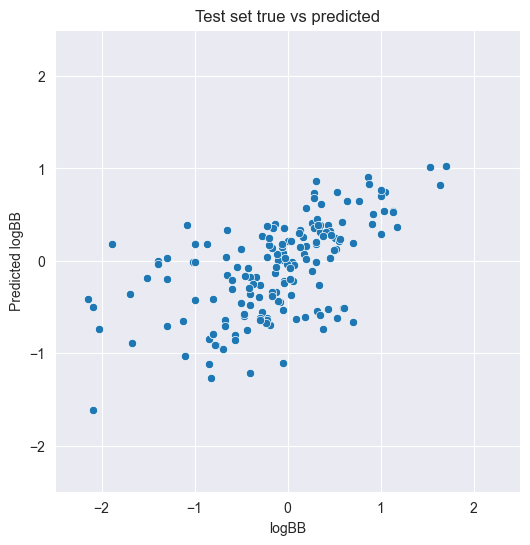

In [174]:
m_reg_final = m_reg
y_te_p_final = m_reg_final.predict(df_test[fs_reg])
print("Final test stats:")
print("  R2   :", r2_score(df_test.logBB, y_te_p_final))
print("  RMSE :", root_mean_squared_error(df_test.logBB, y_te_p_final))

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
sns.scatterplot(x=df_test.logBB, y=m_reg_final.predict(df_test[fs_reg ]), ax=ax)
ax.set_title("Test set true vs predicted")
ax.set_ylabel("Predicted logBB")
ax.set_ylim([-2.5, 2.5])
ax.set_xlim([-2.5, 2.5])
#sns.residplot(x=df_test.logBB, y=m_reg_final.predict(df_test[fs_reg ]))

print("_"*50)
print("Test evaluation details:")
pprint.pprint(evaluate_test(m_reg_final, df_test[fs_reg], df_test.logBB))

print("_"*50)
print("Drug landscape assessment:")
pprint.pprint(evaluate_quant(m_reg_final, lambda x: x[fs_reg]))

## Development of LogBB regression algorithm - XGBoost 

In [175]:
# We have learnt that the extended descriptors achieve much better results on the training (RMSE around 0.44, MSE just below 0.2, which is unrealistic). They also underperform in validation. Since we split by Murcko scaffold, we might want to avoid the influence of particular scaffolds or fractions (i.e. what might have bitten us in the extended set). We therefore rely on the simple if not as easily structure - interpretable descriptors.

In [176]:
# Verification against R47 (~450 compounds). We cannot prove this is a worse dataset this way - i.e. its highly volatile (if I grab first 500 compounds from b3db_kc and split randomly, we can reach R2 of 0.92 and RMSE of 0.18 on test.
# from molfeat.trans import FPVecTransformer
# import datamol
# from utils import smiles_to_mol
# _d47 = pd.read_csv("/Users/ellimilial/Documents/research-platform/research_platform/azure_stallion/reference_data/R47.tsv", sep="\t")
# _d47["mol"] = _d47.smiles.apply(smiles_to_mol)
# with datamol.without_rdkit_log():
#     for dt in ["desc2D", "ecfp-count", "maccs"]:
#         tr = FPVecTransformer(kind =dt, dtype=float, n_jobs=16, verbose=False)
#         _d = pd.DataFrame(tr(_d47["mol"]), columns=[f"{dt}_{c}" for c in tr.columns])
#         _d47 = _d47.join(_d)
# from sklearn.model_selection import train_test_split
# 
# X_tr, X_t, y_tr, yt = train_test_split(_d47, _d47.logBB, random_state=42, test_size=0.2)
# X_tr = X_tr.reset_index()
# X_t = X_t.reset_index()
# m = XGBRegressor()
# sc = StandardScaler()
# f = [c for c in SIMPLE_FILTERED_FEATURES if c not in {"chemaxon_logp", "chemaxon_logd", "chemaxon_pka_b"}]
# m.fit(sc.fit_transform(X_tr[f]), y_tr)
# _p = pd.DataFrame(m.predict(sc.transform(X_tr[f])), columns=["predicted"])
# _z = X_tr.join(_p)[["logBB", "predicted"]]
# print("r2_train", r2_score(_z.logBB, _z.predicted))
# _pt = pd.DataFrame(m.predict(sc.transform(X_t[f])), columns=["predicted"])
# _zt = X_t.join(_pt)[["logBB", "predicted"]]
# print("r2_test", r2_score(_zt.logBB, _zt.predicted))
# print("rmse", root_mean_squared_error(_zt.logBB, _zt.predicted))

In [177]:
from sklearn.model_selection import cross_val_score

m_reg = XGBRegressor(random_state = 42)
# Features from SIMPLE_FILTERED_FEATURES and MACCS fingerprings have been iteratively eliminated based on the guided by feature importance.
#fs_reg = SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs)

fs_reg = [
    "chemaxon_logd",
    "chemaxon_pka_b",
   # "desc2D_NumAliphaticCarbocycles",
    "desc2D_TPSA",
    #"desc2D_NumAliphaticRings",
    #"desc2D_NumAliphaticHeterocycles",
    "desc2D_NumHAcceptors",
   # #"desc2D_NumHDonors",
    #"desc2D_MinAbsPartialCharge",
    #"desc2D_MaxAbsPartialCharge",
    "desc2D_MinPartialCharge",
    #"desc2D_MaxPartialCharge",
    #"desc2D_NumHeteroatoms",
    "desc2D_NumRotatableBonds",
    #"desc2D_AvgIpc",
    "desc2D_MinEStateIndex",
   # "desc2D_MaxEStateIndex",
    "desc2D_MaxEStateIndex",
    #"desc2D_FractionCSP3",
    #"desc2D_NumBridgeheadAtoms",
    #"desc2D_BalabanJ",
    "desc2D_MolWt",
]


r = evaluate_train(copy.deepcopy(m_reg), X_train=df_train[fs_reg], X_groups=df_train.murcko_scaffold_grouped, y_train=df_train.logBB)
print("Training 5-cross CV")
print("R2  :", sum(r["test_r2"])/len(r["test_r2"]))
print("MSE:", -sum(r["test_neg_mean_squared_error"]) / len(r["test_neg_mean_squared_error"]))
print("RMSE:", -sum(r["test_neg_root_mean_squared_error"]) / len(r["test_neg_root_mean_squared_error"]))


m_reg.fit(
    df_train[fs_reg], 
    df_train.logBB
)

# y_tr_p = m_reg.predict(df_train[fs_reg])
# y_tr_class = m_reg.predict(df_train_classification_only[fs_reg])
# y_te_p = m_reg.predict(df_test[fs_reg])
# print("R2 test      :", r2_score(df_test.logBB, y_te_p))
# print("RMSE test    :", root_mean_squared_error(df_test.logBB, y_te_p))

print("Model feature importances: ")
pd.Series(m_reg.feature_importances_, index=fs_reg).sort_values(ascending=False)

Training 5-cross CV
R2  : 0.5201426899292834
MSE: 0.2641226378133629
RMSE: 0.5131219475701481
Model feature importances: 


desc2D_TPSA                 0.501941
chemaxon_pka_b              0.092448
desc2D_MinPartialCharge     0.080849
desc2D_MaxEStateIndex       0.079234
desc2D_MinEStateIndex       0.062394
desc2D_NumRotatableBonds    0.057033
desc2D_MolWt                0.047853
desc2D_NumHAcceptors        0.039341
chemaxon_logd               0.038908
dtype: float32

In [178]:
# Establish a validation dataset for hyperparameter optimisation.
from twinning import twinning

g_scaffold_desc_for_split_mean = df_train[fs_reg + ["murcko_scaffold_grouped"]].groupby("murcko_scaffold_grouped").mean()
_s_validation_scaffolds = set(g_scaffold_desc_for_split_mean.index[twinning.twin(g_scaffold_desc_for_split_mean.to_numpy(), r=5, u1=42)])  
print(f"{len(_s_validation_scaffolds)}/{len(g_scaffold_desc_for_split_mean)} (grouped) Murcko scaffolds assigned to the validation set.")

df_train_validation = df_train[df_train.murcko_scaffold_grouped.apply(lambda x: x in _s_validation_scaffolds)]
df_train_sans_validation = df_train[df_train.murcko_scaffold_grouped.apply(lambda x: x not in _s_validation_scaffolds)]
print(f"Training set is separated into a dedicated validation (N={len(df_train_validation)}), with the remaining datapoints in training sans validation set (N={len(df_train_sans_validation)}) ")

111/555 (grouped) Murcko scaffolds assigned to the validation set.
Training set is separated into a dedicated validation (N=143), with the remaining datapoints in training sans validation set (N=563) 


In [179]:
# # Optimisation.
# 
# xgb_optimisation_space = {
#     'max_depth': hp.uniformint("max_depth", 1, 8),
#     'gamma': hp.uniform ('gamma', 1, 4),
#     'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
#     'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
#     'colsample_bytree' : hp.uniform('colsample_bytree', 0.2, 1),
#     'min_child_weight' : hp.uniformint('min_child_weight', 0, 10),
#     'n_estimators/10': hp.uniformint("n_estimators/10", 1, 12),
#     'seed': 42
# }
# 
# def objective(space):
#     _m = XGBRegressor(
#         random_state = 42,
#         early_stopping_rounds=10, 
#         eval_metric="rmse",
#         n_estimators=space['n_estimators/10'] * 10, 
#         max_depth = (space['max_depth']), 
#         gamma = space['gamma'],
#         reg_alpha = space["reg_alpha"],
#         reg_lambda = space["reg_lambda"],
#         min_child_weight=space['min_child_weight'],
#         colsample_bytree=space['colsample_bytree'],
#     ).fit(
#         df_train_sans_validation[fs_reg], 
#         df_train_sans_validation.logBB,
#         eval_set=[(df_train_sans_validation[fs_reg], df_train_sans_validation.logBB), (df_train_validation[fs_reg], df_train_validation.logBB)], 
#         verbose=False
#     )    
#     p_test = _m.predict(df_test[fs_reg])
#     return {'loss': root_mean_squared_error(df_test.logBB, p_test), 'status': STATUS_OK}
# 
# trials = Trials()
# 
# reg_top_hyperparams = fmin(
#     fn = objective,
#     space = xgb_optimisation_space,
#     algo = tpe.suggest,
#     max_evals = 1000,
#     trials = trials
# )
# print("Optimisation - best hyperparameters:")
# pprint.pprint(reg_top_hyperparams)
# m_reg_opt = XGBRegressor(
#     random_state = 42,
#     early_stopping_rounds=10, 
#     eval_metric="rmse",
#     n_estimators=int(reg_top_hyperparams["n_estimators/10"]) * 10,
#     max_depth=int(reg_top_hyperparams["max_depth"]),
#     gamma=reg_top_hyperparams["gamma"],
#     reg_alpha = reg_top_hyperparams["reg_alpha"],
#     reg_lambda = reg_top_hyperparams["reg_lambda"],
#     min_child_weight=reg_top_hyperparams["min_child_weight"],
#     colsample_bytree=reg_top_hyperparams["colsample_bytree"],
# ).fit(
#     df_train[fs_reg], 
#     df_train.logBB,
#     eval_set=[(df_train[fs_reg], df_train.logBB), (df_test[fs_reg], df_test.logBB)], 
#     verbose=False
# )
# y_te_p_opt = m_reg_opt.predict(df_test[fs_reg])
# print("Post-opt test stats:")
# print("R2 test       :", r2_score(df_test.logBB, y_te_p_opt))
# print("RMSE test     :", root_mean_squared_error(df_test.logBB, y_te_p_opt))

In [180]:
import os

# Optimisation. This does not improve the model.

xgb_optimisation_space = {
    'max_depth': hp.uniformint("max_depth", 1, 4),
    'gamma': hp.uniform ('gamma', 1, 4),
    'reg_alpha' : hp.uniform('reg_alpha', 0.4, 2),
    'reg_lambda' : hp.uniform('reg_lambda', 0.4, 2),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.1, 1),
    'n_estimators/10': hp.uniformint("n_estimators/10", 1, 20),
    'seed': 42
}

def objective(space):
    _m = XGBRegressor(
        random_state = 42,
        early_stopping_rounds=10, 
        eval_metric="rmse",
        n_estimators=space['n_estimators/10'] * 10, 
        max_depth = (space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = space["reg_alpha"],
        reg_lambda = space["reg_lambda"],
        colsample_bytree=space['colsample_bytree'],
    ).fit(
        df_train_sans_validation[fs_reg], 
        df_train_sans_validation.logBB,
        eval_set=[(df_train_sans_validation[fs_reg], df_train_sans_validation.logBB), (df_train_validation[fs_reg], df_train_validation.logBB)], 
        verbose=False
    )    
    p_test = _m.predict(df_train_validation[fs_reg])
    return {'loss': root_mean_squared_error(df_train_validation.logBB, p_test), 'status': STATUS_OK}

trials = Trials()

os.environ["HYPEROPT_FMIN_SEED"] = "42" 
reg_top_hyperparams = fmin(
    fn = objective,
    space = xgb_optimisation_space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials,
)
print("Optimisation - best hyperparameters:")
pprint.pprint(reg_top_hyperparams)

m_reg_opt = XGBRegressor(
    random_state = 42,
    early_stopping_rounds=10, 
    eval_metric="rmse",
    n_estimators=int(reg_top_hyperparams["n_estimators/10"]) * 10,
    max_depth=int(reg_top_hyperparams["max_depth"]),
    gamma=reg_top_hyperparams["gamma"],
    reg_alpha = reg_top_hyperparams["reg_alpha"],
    reg_lambda = reg_top_hyperparams["reg_lambda"],
    colsample_bytree=reg_top_hyperparams["colsample_bytree"],
).fit(
    df_train_sans_validation[fs_reg], 
    df_train_sans_validation.logBB,
    eval_set=[(df_train_sans_validation[fs_reg], df_train_sans_validation.logBB), (df_train_validation[fs_reg], df_train_validation.logBB)], 
    verbose=False
)
y_val_p_opt = m_reg_opt.predict(df_train_validation[fs_reg])
print("Post-opt validation stats:")
print("  R2   :", r2_score(df_train_validation.logBB, y_val_p_opt))
print("  RMSE :", root_mean_squared_error(df_train_validation.logBB, y_val_p_opt))

# y_te_p_opt = m_reg_opt.predict(df_test[fs_reg])
# print("Post-opt test stats:")
# print("  R2   :", r2_score(df_test.logBB, y_te_p_opt))
# print("  RMSE :", root_mean_squared_error(df_test.logBB, y_te_p_opt))

100%|██████████| 100/100 [00:02<00:00, 36.95trial/s, best loss: 0.4709668939187595]
Optimisation - best hyperparameters:
{'colsample_bytree': 0.5192587402906136,
 'gamma': 1.005621147406447,
 'max_depth': 3.0,
 'n_estimators/10': 11.0,
 'reg_alpha': 0.4418317833876404,
 'reg_lambda': 1.030394576906861}
Post-opt validation stats:
  R2   : 0.5564832272103043
  RMSE : 0.4709668939187595


Final test stats:
  R2   : 0.22880069597026487
  RMSE : 0.6543232578013157
__________________________________________________
Test evaluation details:
{'b_accuracy_at_logbb_-0.1': 0.6649085794655415,
 'b_accuracy_at_logbb_-1': 0.5879323031640913,
 'b_accuracy_at_logbb_0': 0.7047255234861347,
 'b_accuracy_at_logbb_0.3': 0.7168803418803419,
 'mean_squared_error': 0.42813892569972706,
 'r2': 0.22880069597026487,
 'root_mean_squared_error': 0.6543232578013157}
__________________________________________________
Drug landscape assessment:
{'fraction_drugs_predicted_BBB+_at_-0.1': 0.3244882486732373,
 'fraction_drugs_predicted_BBB+_at_-1': 0.813747788728835,
 'fraction_drugs_predicted_BBB+_at_0': 0.2754612079858479,
 'fraction_drugs_predicted_BBB+_at_0.3': 0.1498610058124842,
 'train_classification_b_acc_at_-0.1': 0.6841001091282941,
 'train_classification_b_acc_at_-1': 0.6122012655270829,
 'train_classification_b_acc_at_0': 0.672055369913318,
 'train_classification_b_acc_at_0.3': 0.652427512

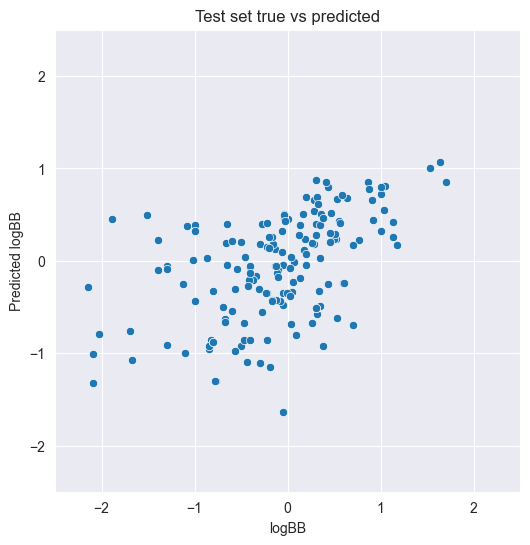

In [181]:
# Optimisation process doesn't result in improving the models.
# m_reg_final = XGBRegressor(
#     random_state = 42,
#     eval_metric="rmse",
#     n_estimators=int(reg_top_hyperparams["n_estimators/10"]) * 10,
#     max_depth=int(reg_top_hyperparams["max_depth"]),
#     gamma=reg_top_hyperparams["gamma"],
#     reg_alpha = reg_top_hyperparams["reg_alpha"],
#     reg_lambda = reg_top_hyperparams["reg_lambda"],
#     colsample_bytree=reg_top_hyperparams["colsample_bytree"],
# ).fit(
#     df_train[fs_reg], 
#     df_train.logBB,
#     verbose=False
# )

m_reg_final = XGBRegressor(
    random_state = 42,
 ).fit(
    df_train[fs_reg], 
    df_train.logBB,
    verbose=False
)

y_te_p_final = m_reg_final.predict(df_test[fs_reg])
print("Final test stats:")
print("  R2   :", r2_score(df_test.logBB, y_te_p_final))
print("  RMSE :", root_mean_squared_error(df_test.logBB, y_te_p_final))

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
sns.scatterplot(x=df_test.logBB, y=m_reg_final.predict(df_test[fs_reg ]), ax=ax)
ax.set_title("Test set true vs predicted")
ax.set_ylabel("Predicted logBB")
ax.set_ylim([-2.5, 2.5])
ax.set_xlim([-2.5, 2.5])
#sns.residplot(x=df_test.logBB, y=m_reg_final.predict(df_test[fs_reg ]))

print("_"*50)
print("Test evaluation details:")
pprint.pprint(evaluate_test(m_reg_final, df_test[fs_reg], df_test.logBB))

print("_"*50)
print("Drug landscape assessment:")
pprint.pprint(evaluate_quant(m_reg_final, lambda x: x[fs_reg]))

In [182]:
print("Final regression model features:")
pprint.pprint(fs_reg)

regression_model_file = "final_regression_model.pkl"
print(f"Saving final model to {regression_model_file}")
with open(regression_model_file, 'wb') as file:
    pickle.dump(m_reg_final, file)

Final regression model features:
['chemaxon_logd',
 'chemaxon_pka_b',
 'desc2D_TPSA',
 'desc2D_NumHAcceptors',
 'desc2D_MinPartialCharge',
 'desc2D_NumRotatableBonds',
 'desc2D_MinEStateIndex',
 'desc2D_MaxEStateIndex',
 'desc2D_MolWt']
Saving final model to final_regression_model.pkl


In [183]:
# Evaluation of the same XGBRegressor on a randomly - split dataset (which does not include Murcko split).
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_b3db_kc_reg, df_b3db_kc_reg.logBB, test_size=0.2, random_state=42)
m_reg_opt_fake = XGBRegressor(
    
).fit(
    X_train[fs_reg], 
    y_train,
    eval_set=[(X_train[fs_reg], y_train), (X_test[fs_reg], y_test)], 
    verbose=False
)
y_test_p = m_reg_opt_fake.predict(X_test[fs_reg])
print("XGBoost model trained and tested on random split:")
print("R2 test       :", r2_score(y_test, y_test_p))
print("RMSE test     :", root_mean_squared_error(y_test, y_test_p))

XGBoost model trained and tested on random split:
R2 test       : 0.49409103652454767
RMSE test     : 0.5091172460257166
